# Time evolution of the experiment

In this notebook, we show how to put to use the class `Thompson` we have built,
to see how, thanks to Thompson sampling, we are able to reconstruct the time evolution of
* the posterior distributions;
* the estimates of the success probabilities;
* regret.

In [1]:
# automatically reloads imported modules after changes in source code

%load_ext autoreload
%autoreload 2

In [3]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import beta
import sys

# Append the ingredient analyzer module by going to the parent folder
sys.path.append("../src")

# Import the analyzer module
from thompson_sampling.thompson_sampling import Thompson

In [4]:
# parameters

sns.set_context("notebook", font_scale=1.4)
# colour-blind friendly palette
cb_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# rounds to iterate over
time_steps = 1000
# experiments to average over
experiments = 500
# bandits with known probabilites
bandit_probs = [0.1, 0.4, 0.45, 0.6, 0.61]

In [5]:
# initialize class
ts = Thompson(bandit_probs, time_steps)

In [6]:
# To remove noise, we average the quantities of interest across 500 experiments.

avg_cumsum_rewards = np.zeros((ts.n_bandits, ts.steps))
avg_cumsum_penalties = np.zeros((ts.n_bandits, ts.steps))
avg_regret = np.zeros(ts.steps)

# run!
for i in range(experiments):
    ts.run_experiment()
    avg_cumsum_rewards += ts.cumsum_rewards
    avg_cumsum_penalties += ts.cumsum_penalties
    avg_regret += ts.regret
    print(f"{i+1}/{experiments} concluded", end='\r')
avg_cumsum_rewards /= experiments
avg_cumsum_penalties /= experiments
avg_regret /= experiments

### Evolution of the posterior distributions

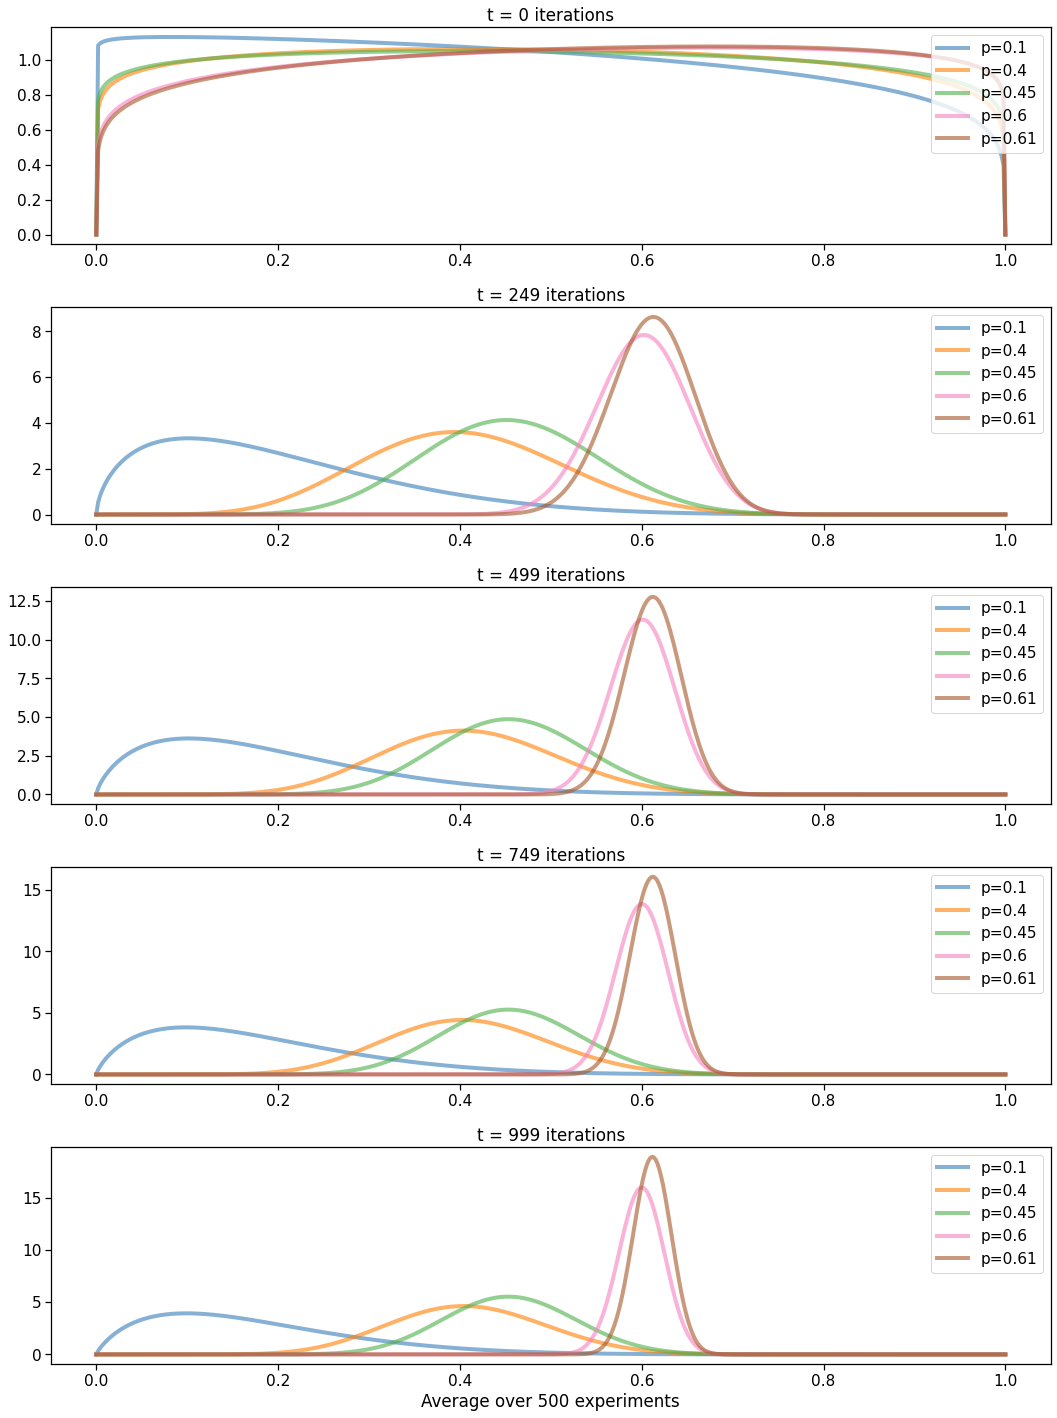

In [7]:
# here a plot of Beta(alpha_k, beta_k) for all bandits k, at 5 equidistant points in time

x = np.linspace(0, 1, 500)
num_plots = 5
snapshots = np.linspace(0, ts.steps -1, num_plots, dtype='int')

fig, axs = plt.subplots(num_plots, figsize=(15,20))

# looping over time
for i in range(0, num_plots):
    
    t = snapshots[i]
    
    # looping over bandits
    for bandit in range(ts.n_bandits):
        axs[i].plot(x, beta.pdf(x,
                                1 + avg_cumsum_rewards[bandit, t],
                                1 + avg_cumsum_penalties[bandit, t]),
                    color=cb_color_cycle[bandit], lw=4, alpha=0.6,
                    label=f"p={bandit_probs[bandit]}")
    axs[i].legend(loc='upper right')
    axs[i].title.set_text(f"t = {t} iterations")
plt.xlabel(f"Average over {experiments} experiments")
plt.tight_layout()
plt.show()

The plots show that over time TS converges to distributions
that are increasingly better sampled (= sharper)
the higher their expectation value is,
striking a balance between exploitation and exploration.

### Evolution of the estimates of the success probabilities

For a beta distribution, the expectation value of the success probability is 

$$E = \dfrac{(\alpha)}{(\alpha + \beta)}$$

In [8]:
# approximate expectation value of the beta distribution
# (slightly modified to avoid division by zero errors)

def expec_val(alpha, beta):
    
    return (1 + alpha) / (1 + alpha + beta)

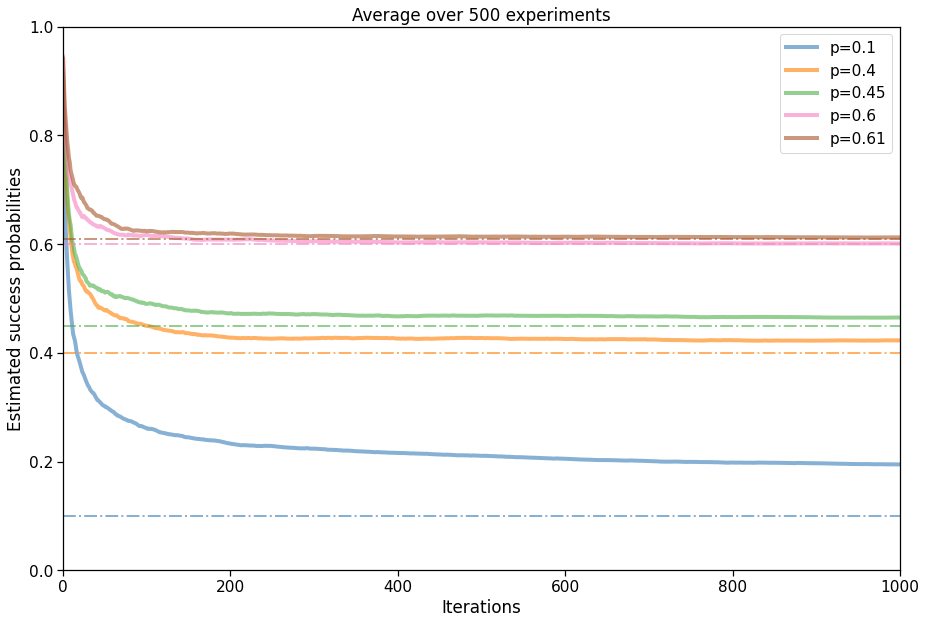

In [9]:
# here a plot of the E_k = alpha_k / (alpha_k, beta_k) for all bandits k, at 5 equidistant points in time

x = np.arange(ts.steps)

fig, ax = plt.subplots(1, figsize=(15, 10))
    
# looping over bandits 
for bandit in range(ts.n_bandits):
    ax.plot(x, expec_val(avg_cumsum_rewards[bandit, x], avg_cumsum_penalties[bandit, x]),
            color=cb_color_cycle[bandit], lw=4, alpha=0.6,
            label=f"p={bandit_probs[bandit]}")
    ax.axhline(y=ts.success_probs[bandit],
               color=cb_color_cycle[bandit], ls ='-.', lw=2, alpha=0.6)
ax.set_xlim(0,ts.steps)
ax.set_ylim(0,1)
ax.legend(loc='upper right')
plt.xlabel("Iterations")
plt.ylabel("Estimated success probabilities")
plt.title(f"Average over {experiments} experiments")
plt.show()

As expected, the expectation value for the two bandits
with the highest success probabilities (0.6 and 0.61)
converged closest to their true value (shown in the dashed-dotted lines).
Bandits with lower success probability have been explored less,
leading to estimates that are progressively further away from their true values.

### Evolution of regret

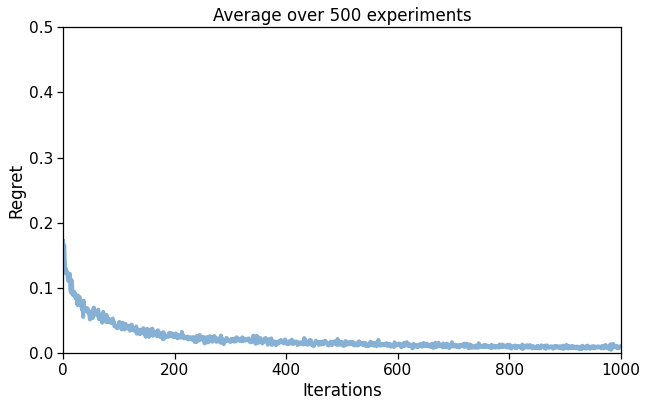

In [10]:
# here a plot of ts.regret against time

x = np.arange(ts.steps)

fig = plt.figure(figsize=(10, 6))
    
plt.plot(x, avg_regret[x],
         color=cb_color_cycle[0], lw=4, alpha=0.6)

plt.xlim(0,ts.steps)
plt.ylim(0,0.5)
plt.xlabel("Iterations")
plt.ylabel("Regret")
plt.title(f"Average over {experiments} experiments")
plt.show()

This shows that the average regret in our simulations succesfully converges to zero.

### Summary

* The algorithm comes quite close to guessing the best success probability,
    and increasingly worse in its estimate of the other ones
    as the true values decrease.
* This relates to the fact that bandits with lower success probability
    quickly see their probability of being sampled lowered,
    as TS switches its focus to more promising bandits.
    Therefore, the posterior probability with the highest expectation value
    is also the one with the lowest standard deviation.
* The average regret, or the difference between the max success probability
    and the success probability of the picked option,
    asymptotically converges to zero,
    indicating that TS is converging to the optimal solution.

### Possible performance improvements?

* A possible improvement might come from tweaking the $\alpha$ and $\beta$ parameters,
    in order to more strongly skew the tendency of TS towards exploitation vs exploration, respectively.
    However, fiddling with these parameters (halving/doubling)
    we observed a significant decrease in the estimates and convergence.
    (Not shown here. To try it out,
    modify parameters `self.damp_alpha` and `self.damp_beta` in script).
* Another possible improvement could come from changing the initial conditions.
    In the simulation above, we have initialized each bandit with a Beta distribution
    having $\alpha = \beta = 0$.
    Were some intuition of the true success probabilities available
    (while still not enough to go supervised learning on),
    it could be used to give the simulation a better head start.
    Since this is not the case for our problem, we simply tried starting off with $\alpha = 1, \beta = 0$.
    This did however not increase our results.
    (Not shown here. To try it out,
    modify parameters `self.alpha_init` and `self.beta_init` in script).
* Finally, a different strategy is so called *optimistic* TS,
    in which a lower bound is put on the sampling from the posterior probability.
    This can be viewed as a level of caution against poor performance.
    Again, while introducing e.g. a $\theta_{min} = 0.1$
    does marginally improve performance, because indeed that is the lowest 
    of the bandits' success probabilities, we (supposedly) have no prior information at hand
    to justify such an assumption in the initial problem setting.
    (Not shown here. To try it out,
    set parameter `self.optimistic = True` in script).